After getting familiar with time series components and stationarity, readers are ready to move on to modeling a time series. In this module, you will use some of the well-known classical time series models to make predictions.

## Time Series Models

After briefly visiting the theory of time series, it is time to discuss the main time series models, which are:

* Naive Method
* Simple Average Method
* Moving Average (MA) model
* Autoregressive Average
* Single exponential smoothing
* Double exponential smoothing
* Holt-Winter Exponential Smoothing


## Naive Method

Naive method is one the basic time series models. This model proposes a prediction at time t by considering t-1 only.

The theory behind Naive model is that simple and so is its application. However, before going into the modeling stage, there is one step that we need to take for all time series models:`Splitting data`

Splitting data into training and test is essential in time series as in other models. But let's briefly discuss why it is that important?

The reason is that if we do not split the data, model cannot generalize the result. That is to say, train data is used in fitting (or learning) stage and test data (unseen data) put aside so that we can run prediction based on a data, which is unseen by model before.

Shortly, in the training stage, model learn from train data and then in the prediction part, model applies what it has learned using test data.

As you can imagine, there are different methods applicable to train-test split but time series analysis requires a special one as we have sequence in time. With that being said, we are going to apply train-test split based on time.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
import datetime
import yfinance as yf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [53]:
stock = 'TSLA'
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2022, 8, 1)
tsla_close = yf.download(stock, start=start, end=end, interval='1d')['Close']

[*********************100%***********************]  1 of 1 completed


In [54]:
train_len = int(len(tsla_close) * 0.8)
train = tsla_close[:train_len]
test = tsla_close[train_len:]

In [55]:
predictions = pd.DataFrame()
predictions.index = test.index
predictions['naive_model'] = train[train_len-1]

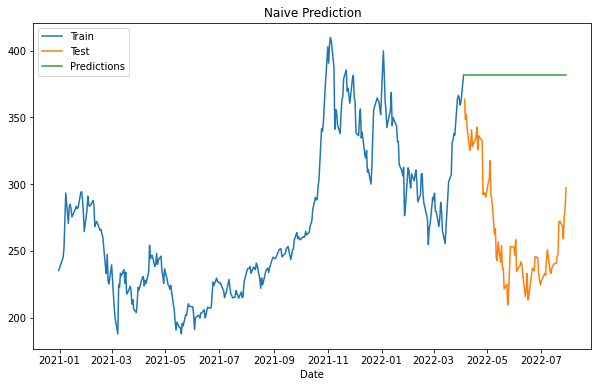

In [56]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions['naive_model'], label='Predictions')
plt.title('Naive Prediction')
plt.legend()
plt.xlabel('Date')
plt.show()

All right, as it is readily observable, naive method is so naive that it only takes into account the value at time t-1 and run prediction based on it. In order to have a better predictive performance from this model, the time at which you start your prediction it is of considerable importance.

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_naive = mean_absolute_error(test, predictions['naive_model'])
mse_naive = mean_squared_error(test, predictions['naive_model'])
rmse_naive = np.sqrt(mean_squared_error(test, predictions['naive_model']))

In [58]:
naive_perf = {'mae_naive': mae_naive,
             'mse_naive':mse_naive,
             'rmse_naive':rmse_naive}
naive_perf = pd.DataFrame([naive_perf])
naive_perf

,mae_naive,mse_naive,rmse_naive
0,116.716305,15290.930943,123.656504


## Simple Moving Average Model 

This model is the simplest moving average model. It is based on an arithmetic moving average. That is to say, simple average model forecasts next values using the average of a fixed finite number, say n, of the previous values. Mathematically,

\begin{equation}
\hat{y} = \frac{1}{n}\Sigma_{j=t-n}^{t-1} (y_{t-1} + y_{t-2} + \cdots y_{t-n})
\end{equation}

As simple average method is calculated based on average price over a specificied period, it is used to identify trend:
    
* If simple average method goes up, it indicates a positive trend
* If simple average method goes down, it indicates a negative trend

Now, the question is how we pick the number `n` by which we run simple average model?

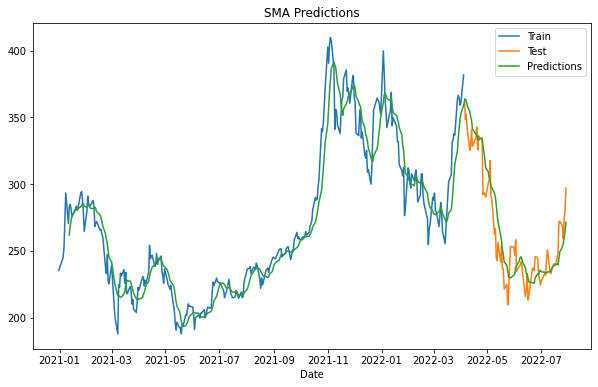

In [63]:
sma = tsla_close.rolling(8).mean()
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(sma.index, sma, label='Predictions')
plt.title('SMA Predictions')
plt.legend()
plt.xlabel('Date')
plt.show()

In [64]:
mae_sma = mean_absolute_error(test,sma.loc['2022-04-05':])
mse_sma = mean_squared_error(test, sma.loc['2022-04-05':])
rmse_sma = np.sqrt(mean_squared_error(test, sma.loc['2022-04-05':]))

In [65]:
sma_perf = {'mae_sma': mae_sma,
             'mse_sma':mse_sma,
             'rmse_sma':rmse_sma}
sma_perf = pd.DataFrame([sma_perf])
sma_perf

,mae_sma,mse_sma,rmse_sma
0,12.371443,245.448084,15.666783


Please note that when we run rolling window, we do not need to use train-test split that we created before as it rolls over all the period. 

Besides, we have not used stationary data in naive and simple average model. But, from this model on, we are going to run regression-based time series models and stationary data is required.

Let's continue with moving average model.

## Moving Average Model

`Moving average`model tries to capture the time series dynamics simply by error terms. Let $e_t$ is a normally distributed term, meaning that it is identically and independently distributed (iid). So, unlike AR, MA is alway stationary.

MA(1) can be take the following form:

\begin{equation} X_{t} = \alpha + \beta \epsilon_{t-1} + \epsilon_{t} \end{equation}



Similarly, the $q_{th}$ order moving average model can be shown as MA(q):

\begin{equation} X_{t} = \alpha + \beta_1 \epsilon_{t-1} +\cdots+\beta_q \epsilon_{t-q} +\epsilon_{t} \end{equation}

Modeling a time series with MA in Python is not very different from modeling AR. The only difference is the location of the order (lag) parameter. The first parameter of order represent the number of lag values of AR whereas the second input of order in ARMA defines the number of lag values in modeling MA. A quick note: As the MA works with the windows, less order number might result in bad prediction.

In [66]:
tsla_diff = tsla_close.diff().dropna()

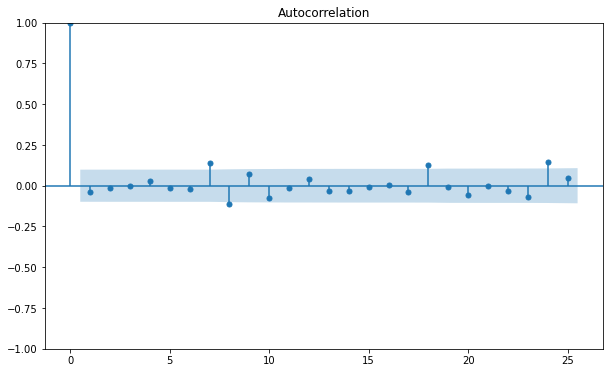

In [67]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(tsla_diff, lags=25);

Modeling a time series with MA in Python is not very different from modeling AR. The only difference is the location of the order (lag) parameter. The first parameter of order represent the number of lag values of AR whereas the second input of order in ARMA defines the number of lag values in modeling MA. A quick note: As the MA works with the windows, less order number might result in bad prediction.

Let's decide the best-fitting MA model. But before moving forward, I need to calculate the first difference and drop the missing values to not to get `exog contains inf or nans` error.

In [68]:
from statsmodels.tsa.arima.model import ARIMA

In [69]:
train_len = int(len(tsla_diff) * 0.8)
diff_train = tsla_diff[:train_len]
diff_test = tsla_diff[train_len:]

In [103]:
start = len(diff_train)
end = len(diff_train) + len(diff_test) - 1

In [71]:
ma_model = ARIMA(diff_train, order=(0, 0, 8))
ma_result = ma_model.fit()

At this point, it is worthwhile to discuss the difference of in-sample and out-of-sample forecasts. Simple put, if we predict for an observation that is part of the data, then it is a in sample-forecast. If we predict for an observation that is not part of the data, it is refered to as out-of-sample forecast. Please note that some textbooks call in-sample forecast as prediction and out-of-sample as forecast. We can also follow this convention.

In [72]:
ma_pred = ma_result.predict(start, end)
ma_pred.index = diff_test.index

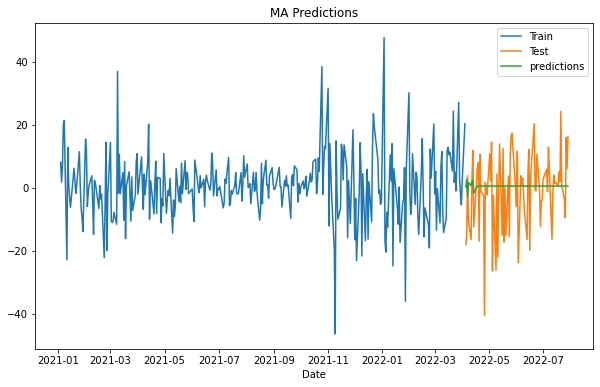

In [73]:
plt.plot(diff_train.index, diff_train, label='Train')
plt.plot(diff_test.index, diff_test, label='Test')
plt.plot(ma_pred.index , ma_pred, label='predictions')
plt.title('MA Predictions')
plt.legend()
plt.xlabel('Date')
plt.show()

In [74]:
mae_ma = mean_absolute_error(diff_test, ma_pred)
mse_ma = mean_squared_error(diff_test, ma_pred)
rmse_ma = np.sqrt(mean_squared_error(diff_test, ma_pred))

In [75]:
ma_perf = {'mae_ma': mae_ma,
             'mse_ma':mse_ma,
             'rmse_ma':rmse_ma}
ma_perf = pd.DataFrame([ma_perf])
ma_perf

,mae_ma,mse_ma,rmse_ma
0,9.234438,150.1702,12.254395


In [76]:
ma_model = ARIMA(tsla_diff, order=(0, 0, 8))
ma_result = ma_model.fit()

In [110]:
forecast_index = pd.date_range(diff_test.index[-1], periods=10)

In [78]:
ma_forecast = ma_result.forecast(steps=10)
ma_forecast.index = forecast_index

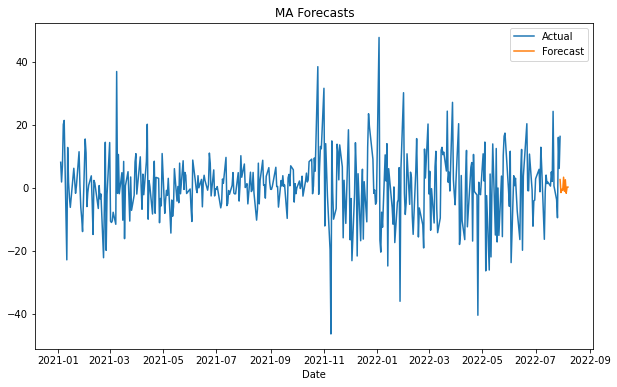

In [79]:
plt.plot(tsla_diff.index, tsla_diff, label='Actual')
plt.plot(ma_forecast.index, ma_forecast, label='Forecast')
plt.legend()
plt.title('MA Forecasts')
plt.xlabel('Date')
plt.show()

The predictive performance of MA is better than the models that we have visited so far. Satisfactory forecasting analysis can be expected accordingly.

## Autoregressive Model

`Autoregressive model` (AR) is one of the most basic models in time series. As its name suggest, we regress the current value of a series over its lagged values. So, it is based on the idea that current values of series $x_t$ can be accounted for as a function of past values.

Different lag values can be employed to explain the current value of $x_t$. Symbolically, AR(p) denotes that $x_t$ is explained by p past values of $x_t$.

For the sake of simplicity, AR(1) model can be represented by the following equation:

\begin{equation} X_{t} = \alpha + \beta X_{t-1} + \epsilon_t \end{equation}

Let us generalize the AR model as AR(p):

\begin{equation} X_{t} = \alpha + \beta X_{t-1} + \cdots +  \beta X_{t-p} + \epsilon_t \end{equation}

To sum up, the autoregressive model uses historical observations as input to a regression equations to predict the value at the next step. There is only one parameter we need to use in AR model, which is p. This determines how many previous time steps will be inputted.

The order, p, of the autoregressive model can be deterimined by looking at the PACF. 

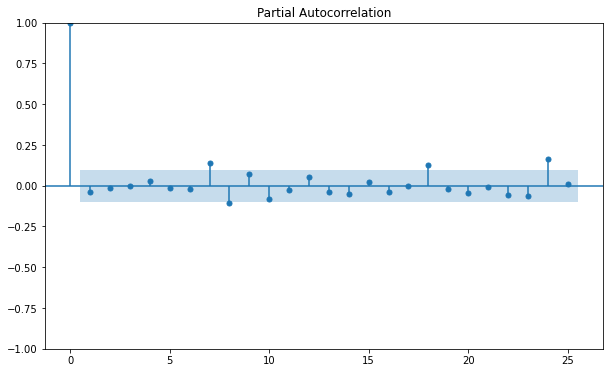

In [80]:
sm.graphics.tsa.plot_pacf(tsla_diff, lags=25);

The PACF shows some spikes at lag 7 and 8 in short horizon. In fact, we can also use spikes occured at longer horiozons such as 18 and 24. But please keep this in mind, if you put more and more parameters, your model tend to overfit. For more information about overfitting, please refer to [here](https://en.wikipedia.org/wiki/Overfitting).

In [81]:
ar_model = ARIMA(diff_train, order=(8, 0, 0))
ar_result = ar_model.fit()

In [82]:
ar_pred = ar_result.predict(start, end)
ar_pred.index = diff_test.index

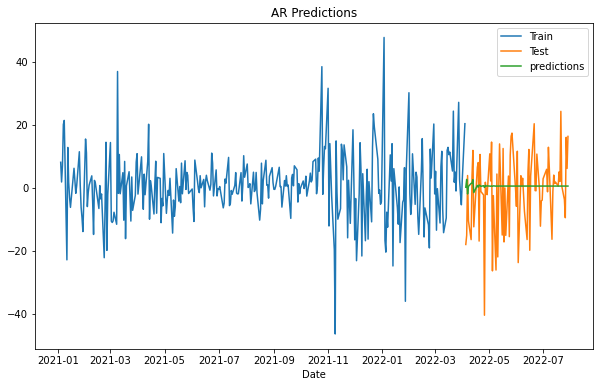

In [83]:
plt.plot(diff_train.index, diff_train, label='Train')
plt.plot(diff_test.index, diff_test, label='Test')
plt.plot(ar_pred.index , ar_pred, label='predictions')
plt.title('AR Predictions')
plt.legend()
plt.xlabel('Date')
plt.show()

In [84]:
mae_ar = mean_absolute_error(diff_test, ar_pred)
mse_ar = mean_squared_error(diff_test, ar_pred)
rmse_ar = np.sqrt(mean_squared_error(diff_test, ar_pred))

In [85]:
ar_perf = {'mae_ar': mae_ar,
             'mse_ar':mse_ar,
             'rmse_ar':rmse_ar}
ar_perf = pd.DataFrame([ar_perf])
ar_perf

,mae_ar,mse_ar,rmse_ar
0,9.218633,149.553995,12.229227


Let's run a 10-step forecasting analysis.

In [83]:
ar_model = ARIMA(tsla_diff, order=(8, 0, 0))
ar_result = ar_model.fit()

In [86]:
ar_forecast = ar_result.forecast(steps=10)
ar_forecast.index = forecast_index

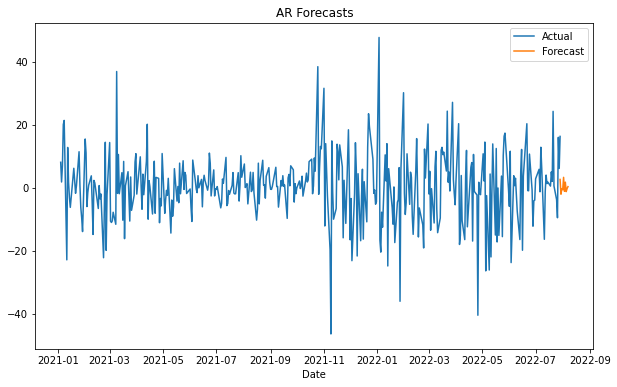

In [87]:
plt.plot(tsla_diff.index, tsla_diff, label='Actual')
plt.plot(ar_forecast.index, ar_forecast, label='Forecast')
plt.legend()
plt.title('AR Forecasts')
plt.xlabel('Date')
plt.show()

AR model outperforms all other models discussed so far.


From this point on up to the end of this module, we will talk about smoothing models. Smoothing models is to construct forecasts of future values as weighted averages of past observations with the more recent observations carrying more weight in determining forecasts than observations in the more distant past.

However, we can smooth out the historical observations in different ways. First off, single exponential smoothing will be our focus. Let's get started!

## Single exponential smoothing

The simplest of the exponentially smoothing methods is called simple exponential smoothing (SES). This method is suitable for forecasting data with no clear trend or seasonal pattern. So, this model might not be an optimal choice for our data as we detected trend, there is no harm in visiting it.

Let us define the $\hat{y}$ that we predict:

\begin{equation}
\hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2} + \cdots
\end{equation}

where $\alpha$ is the smoothing parameter and  $0 \leq\alpha  \leq1$. So, The one-step-ahead forecast for time T+1 is a weighted average of all of the observations in the series, $y_1,\cdots y_T$. The rate at which the weights decrease is controlled by the parameter $\alpha$.

All these imply that in simple exponential smoothing, only the level components is included. As a reminder, level means average value in a time series. Also, we have a smoothing equation. These two form simple exponential smoothing model.

**Forecast equation**

\begin{equation}
\hat{y}_{t+1|t} = l_t
\end{equation}

**Smoothing equation**

\begin{equation}
l_t = \alpha y_t + (1-\alpha) l_{T-1}
\end{equation}

where $l_t$ is the level of the series at time t.

The forecast equation implies that the forecast value at time t+1 is the estimated level at time t. The smoothing equation for the level gives the estimated level of the series at each period t.

Before moving on the modeling part, there is one thing we should keep in mind: Exponential smoothings methods are appropriate for non-stationary data meaning that it is not required to use differenced of the data.

In [13]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
ses = SimpleExpSmoothing(train).fit()

In this model, by not choosing optimize parameter as `False`, the $\alpha$ parameter is automatically optimized.

In [153]:
start = len(train)
end = len(train) + len(test) - 1

In [16]:
ses_pred = ses.predict(start, end)
ses_pred.index = test.index

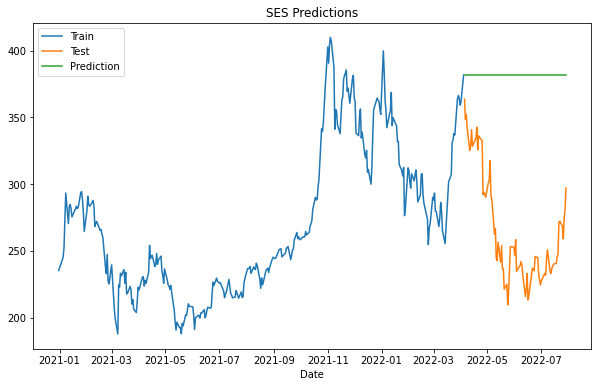

In [18]:
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(ses_pred.index, ses_pred, label='Prediction')
plt.title('SES Predictions')
plt.xlabel('Date')
plt.legend()
plt.show()

In [20]:
mae_ses = mean_absolute_error(test, ses_pred)
mse_ses = mean_squared_error(test, ses_pred)
rmse_ses = np.sqrt(mean_squared_error(test, ses_pred))

In [21]:
ses_perf = {'mae_ses': mae_ses,
             'mse_ses':mse_ses,
             'rmse_ses':rmse_ses}
ses_perf = pd.DataFrame([ses_perf])
ses_perf

,mae_ses,mse_ses,rmse_ses
0,116.608264,15265.722258,123.554532


In [22]:
forecast_index = pd.date_range(test.index[-1], periods=10)
forecast_index

DatetimeIndex(['2022-07-29', '2022-07-30', '2022-07-31', '2022-08-01',
               '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05',
               '2022-08-06', '2022-08-07'],
              dtype='datetime64[ns]', freq='D')

In [24]:
ses_results = SimpleExpSmoothing(tsla_close).fit()
ses_forecast = ses_results.forecast(steps=10)
ses_forecast.index = forecast_index

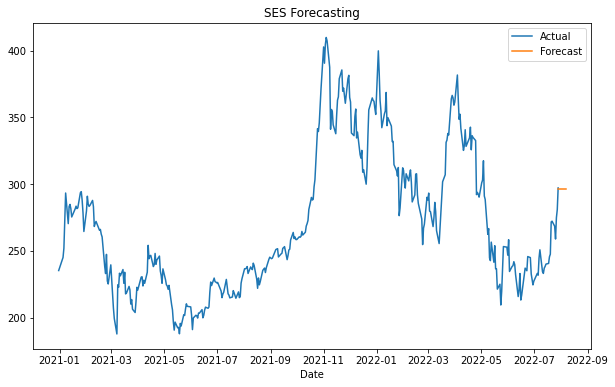

In [26]:
plt.plot(tsla_close.index, tsla_close, label='Actual')
plt.plot(ses_forecast.index, ses_forecast, label='Forecast')
plt.title('SES Forecasting')
plt.legend()
plt.xlabel('Date')
plt.show()


Single exponential model heavily depends on the average historical observations, the forecasted also produces straight line as we have in prediction part.

## Double exponential smoothing

As we have discussed before, single exponential smoothing does not work well when there is a trend. Double exponential smoothing is an attempt to solve this issue. To accomplish this task,another equation is introduced with a $\gamma$ constant, which must be chosen in conjunction with $\alpha$.

\begin{equation}
b_t = \gamma(l_t−l_{t−1})+(1−\gamma)b_{t−1}
\end{equation}

where $b_t$  denotes an estimate of the trend of the time series at time t and \$gamma$ is the other smoothing parameter with $0 \leq \gamma \leq1$.

So, double exponential smoothing augments the single exponential model with trend parameter, i.e., $\gamma$. So, it produces more realiable result in the presence of trend.

In modeling, we make use of Holt's library. Because of Holt's model uses two parameters, one for the `overall smoothing` and the other for the `trend smoothing` equation, it is called `double exponential smoothing`.

In [37]:
des_model = Holt(train)
des_results = des_model.fit(smoothing_level=0.3, smoothing_slope=0.5)

In [38]:
des_pred = des_results.predict(start, end)
des_pred.index = test.index

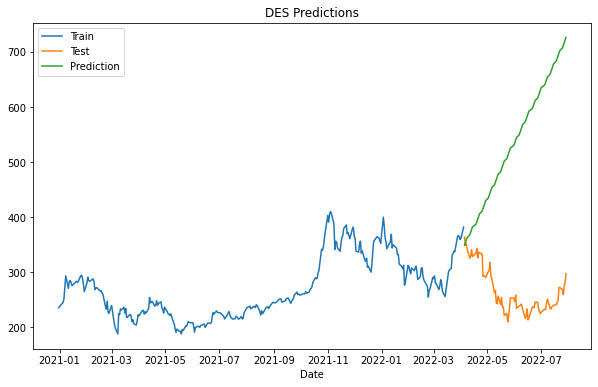

In [39]:
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(des_pred.index, des_pred, label='Prediction')
plt.title('DES Predictions')
plt.xlabel('Date')
plt.legend()
plt.show()

Well, as expected, double exponential smoothing model can capture the trend and generate a prediction accordingly. But it turns out our prediction is not working well as this is a downward slope in test data. So, our prediction and actual data (test) go in opposite direction.

In [40]:
mae_des = mean_absolute_error(test, des_pred)
mse_des = mean_squared_error(test, des_pred)
rmse_des = np.sqrt(mean_squared_error(test, des_pred))

In [41]:
des_perf = {'mae_des': mae_des,
             'mse_des':mse_des,
             'rmse_des':rmse_des}
des_perf = pd.DataFrame([des_perf])
des_perf

,mae_des,mse_des,rmse_des
0,272.661006,94011.637238,306.613172


In [42]:
des_results = Holt(tsla_close).fit()
des_forecast = des_results.forecast(steps=10)
des_forecast.index = forecast_index

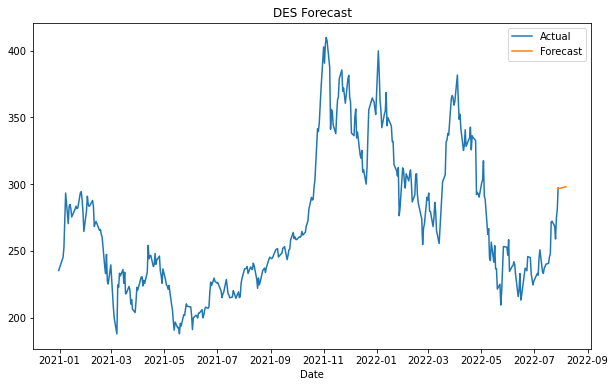

In [43]:
plt.plot(tsla_close.index, tsla_close, label='Actual')
plt.plot(des_forecast.index, des_forecast, label='Forecast')
plt.title('DES Forecast')
plt.xlabel('Date')
plt.legend()
plt.show()

Double exponential capture trend as we can see in the prediction part. However, in the forecasting, it just produces straight line as in single exponential smoothing. 

## Holt-Winter Exponential Smoothing

Holt and Winters augmented Holt’s method to capture seasonality. So, now, in Holt's Winter method, we have three parameters:

* Level ($\alpha_t$)
* Trend ($\gamma_t$)
* Seasonality ($s_t$)

Therefore, in obtaining Holt's Winter model, we need to add one more equation, that is seasonality equation. Let's combine all the smoothing equations to end up with Holt's Winter model.

\begin{equation}
\hat{y}_{t+1|t} = l_t + hb_t + s_{t+h-m}(k+1)
\end{equation}

\begin{equation}
l_t = \alpha y_t + (1-\alpha) l_{T-1}
\end{equation}

\begin{equation}
b_t = \gamma(l_t−l_{t−1})+(1−\gamma)b_{t−1}
\end{equation}

\begin{equation}
s_t = \beta(y_t-l_{t-1} - b_{t-1}) + (1 - \beta)s_{t-m}
\end{equation}

As we know that in double exponential smoothing the trend is constant in the future and it is problematic. In Holt's Winter model, `damped` parameter can handle this issue in a way that trend converges to a constant value.

The problem with Holt’s Linear trend method is that the trend is constant in the future, increasing or decreasing indefinitely. For long forecast horizons, this can be problematic. The damped trend method is therefore a method which add a dampening parameter so that the trend converges to a constant value in the future (it flattens the trend).

Let's run the Holt's Winter with multiplicative trend (`mul`), no seasonality, and damped.

In [44]:
holt_results = ExponentialSmoothing(train, trend='mul', seasonal=None, damped=True).fit()


In [45]:
holt_pred = holt_results.predict(start, end)
holt_pred.index = test.index

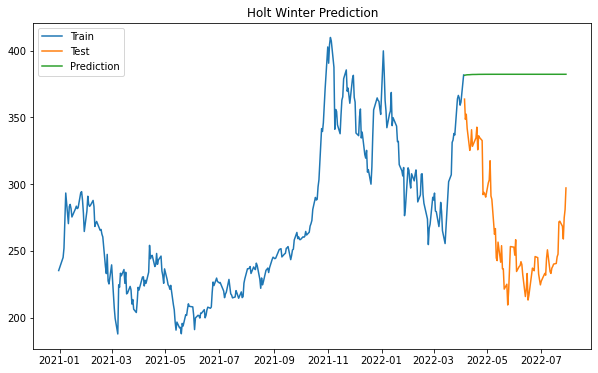

In [46]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(holt_pred, label='Prediction')
plt.legend()
plt.title('Holt Winter Prediction')
plt.show()

The green line plot showing the prediction exhibits that predictions based on Holt's Winter model go down first and then reverts back and generate straight line similar to single exponential smoothing model.

In [47]:
mae_holt = mean_absolute_error(test, holt_pred)
mse_holt = mean_squared_error(test, holt_pred)
rmse_holt = np.sqrt(mean_squared_error(test, holt_pred))

In [48]:
holt_perf = {'mae_holt': mae_holt,
             'mse_holt':mse_holt,
             'rmse_holt':rmse_holt}
holt_perf = pd.DataFrame([holt_perf])
holt_perf

,mae_holt,mse_holt,rmse_holt
0,117.223583,15417.054101,124.16543


In [49]:
holt_results = ExponentialSmoothing(tsla_close, trend='mul', seasonal=None, damped=True).fit()
holt_forecast = holt_results.forecast(steps=10)
holt_forecast.index = forecast_index

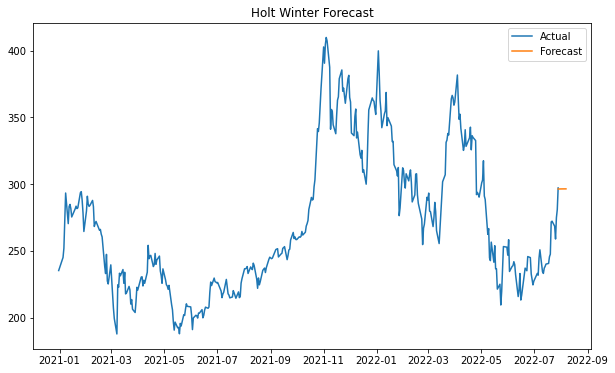

In [50]:
plt.plot(tsla_close, label='Actual')
plt.plot(holt_forecast, label='Forecast')
plt.legend()
plt.title('Holt Winter Forecast')
plt.show()

Forecasting performance of the Holt Winter's model is very similar to other smoothing model as it generates constant forecast value that provides straight line as can be seen in the above-given graph.

Well, that is for this module.

# Performance Measurement

Let's have a break in discussing models and talk about how the performance of these models can be measured. As you can guess, there are many different metrics that can be used in time series analysis. However, for the sake of brevity, let us mention three prominent performance measures:

* Mean Absolute Error (MAE)
* Mean Squared Error (MSE)
* Root Mean Squared Error (RMSE)

## Mean Absolute Error

This is a commonly used performance evaluation metric in regression models. In words, absolute error is the absolute value of the difference between the predictions value and the actual observations. This indicates us how large the model predictions' deviation from the actual values on average.  The MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. 

\begin{equation}
MAE = \frac{1}{n}\Sigma_{i=1}^{n}|\hat{y_i} - y_i|
\end{equation}

where $\hat{y}$ is the predictions, y is the actual values and finally n is the number of observations.

**Advantages**

* In the presence of outliers, it tends to be more robust.
* Output variable has the same units

**Disadvantages**

* As it is non-differentiable, it cannot be used in optimizers like gradient descent
* Bigger errors are failed to be punished

## Mean Squared Error

Similar to MAE, MSE tells us the extent to which predictions deviates from actual values. But the way it is calculated is a bit different from MAE. MSE is calculated by taking the differences between predictions and actual values and square them. The squaring is necessary to remove any negative signs. It also gives more weight to larger differences. 

\begin{equation}
MSE = \frac{1}{n}\Sigma_{i=1}^{n}(\hat{y_i} - y_i)^2
\end{equation}

**Advantage**

* As it is differentiable, it can be used as a loss function

**Disadvantages**
* Not robust to outliers
* If the errors are smaller than 1, it may lead to underestimate the model's badness.

## Root Mean Squared Error

This is another similar performance metric. To compute RMSE, calculate the difference between prediction and actual values, compute the norm of residual for each data point, compute the mean of difference and take the square root of that mean.

Mathematically,

\begin{equation}
RMSE = \sqrt{\frac{\Sigma_{i=1}^{n}|\hat{y_i} - y_i|^2}{n}}
\end{equation}

**Advantages**

* As it is differentiable, it can be used as a loss function

**Disadvantages**
* Not robust to outliers.

In [92]:
basic_perf = pd.concat([naive_perf.T, sma_perf.T, ma_perf.T, ar_perf.T, ses_perf.T, des_perf.T, holt_perf.T])
basic_perf = basic_perf.rename(columns={0:'results'})

In [96]:
basic_mae = basic_perf[basic_perf.index.str.contains('mae')]
basic_mae.sort_values(by=['results'], ascending=True)

,results
mae_ar,9.218633
mae_ma,9.234438
mae_sma,12.371443
mae_ses,116.608264
mae_naive,116.716305
mae_holt,117.223583
mae_des,272.661006


In [99]:
basic_mse = basic_perf[basic_perf.index.str.contains('^mse')]
basic_mse.sort_values(by=['results'], ascending=True)

,results
mse_ar,149.553995
mse_ma,150.170200
mse_sma,245.448084
mse_ses,15265.722258
mse_naive,15290.930943
mse_holt,15417.054101
mse_des,94011.637238


In [100]:
basic_rmse = basic_perf[basic_perf.index.str.contains('rmse')]
basic_rmse.sort_values(by=['results'], ascending=True)

,results
rmse_ar,12.229227
rmse_ma,12.254395
rmse_sma,15.666783
rmse_ses,123.554532
rmse_naive,123.656504
rmse_holt,124.165430
rmse_des,306.613172


To sum up, moving average and autoregressive model outperform the other models based on all metrics. Additionally, Holt Winter and double exponential smoothing model perform poorly. The reason of this poor performance is that our data does not have seasonality and trend changes between train and test data and these two models are unable to capture these differences.

# Advanced Time Series Models

## Autoregressive Moving Average

Thus far, we have, first, tried to model a series by regressing current value of it on its past values , which is referred to as AR model. Then, error terms are taken into account to model a series, which is called MA. How about combining these two? 

Here we have a model called `ARMA` combining both autoregressive and moving average components. So, we have 2 parameters to define: order of AR component p and order of MA component q.

The ARMA model takes the following form when p and q is 1:

\begin{equation} X_{t} = \alpha + \beta_{1} X_{t-1} + \beta_{2} \epsilon_{t-1} + \epsilon_{t} \end{equation}

If you are dealing with another ARMA model, say ARMA(2, 3), the equation takes the following form:

\begin{equation} X_{t} = \alpha + \beta_{1} X_{t-1} +\beta_{2} X_{t-2}+ \beta_{3} \epsilon_{t-1} +\beta_{4} \epsilon_{t-2}+\beta_{5} \epsilon_{t-3}+ \epsilon_{t} \end{equation}

Let's make some practice and we need to find the optimal number of lags.

In [101]:
from statsmodels.tsa.arima.model import ARIMA

In [102]:
arma_model = ARIMA(diff_train, order=(8, 0, 8))
arma_result = arma_model.fit()


In [104]:
arma_pred = arma_result.predict(start, end)
arma_pred.index = diff_test.index

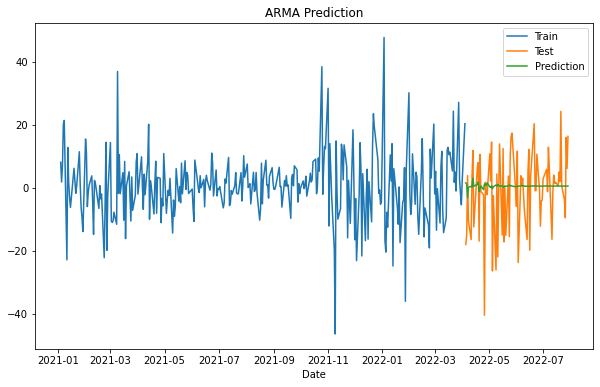

In [105]:
plt.plot(diff_train, label='Train')
plt.plot(diff_test, label='Test')
plt.plot(arma_pred, label='Prediction')
plt.title('ARMA Prediction')
plt.legend()
plt.xlabel('Date')
plt.show()

In [106]:
mae_arma = mean_absolute_error(diff_test, arma_pred)
mse_arma = mean_squared_error(diff_test, arma_pred)
rmse_arma = np.sqrt(mean_squared_error(diff_test, arma_pred))

In [107]:
arma_perf = {'mae_arma': mae_arma,
             'mse_arma':mse_arma,
             'rmse_arma':rmse_arma}
arma_perf = pd.DataFrame([arma_perf])
arma_perf

,mae_arma,mse_arma,rmse_arma
0,9.229375,150.061174,12.249946


In [112]:
arma_model = ARIMA(tsla_diff, order=(8, 0, 8)).fit()
arma_forecast = arma_model.forecast(steps=10)
arma_forecast.index = forecast_index

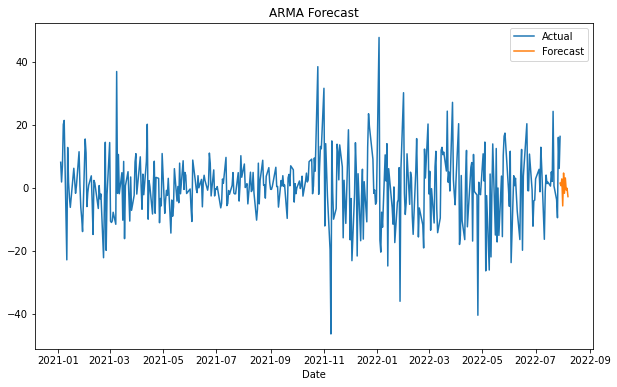

In [113]:
plt.plot(tsla_diff, label='Actual')
plt.plot(arma_forecast, label='Forecast')
plt.title('ARMA Forecast')
plt.xlabel('Date')
plt.legend()
plt.show()

Looking at the predictive performance of this model, except for the MAE, it is the best-performing model so far. As ARMA has a good predictive performance, we can also expect a satisfactory forecasting performance as well.

Well, the next topic is ARIMA, this is an extended version of ARMA.

## Autoregressive Integrated Moving Average

As we discuss the stationary assumption should be satisfied in modeling a time series. In the presence of non-stationarity, first difference needs to be taken before running AR, MA, and ARMA. However, it is not the case for `Autoregressive Integrated Moving Average`(ARIMA) in that we have `Integration` term. So, before running ARIMA, all we need to do specify the degree of difference along with two other parameters borrowed from ARMA(p,q). In a nutshell, ARIMA(p,d,q) has three parameters and one of is for making a series stationary.

The first and third parameters of ARIMA is coming from AR and MA components, respectively and as we can guess the second parameter represents the order of difference.

\begin{equation} X_{t} = \alpha + \beta_{1} X_{t-1} + \beta_{2} \epsilon_{t-1} + \epsilon_{t} \end{equation}

\begin{equation} Z_t = X_{t+1} - X_{t}\end{equation}

To use ARIMA, we again use `statsmodels` but now import `ARIMA` library:

In [118]:
arima_model = ARIMA(train, order=(8,1,8))
arima_results = arima_model.fit()

In [121]:
arima_predict = arima_results.predict(start, end)
arima_predict.index = test.index

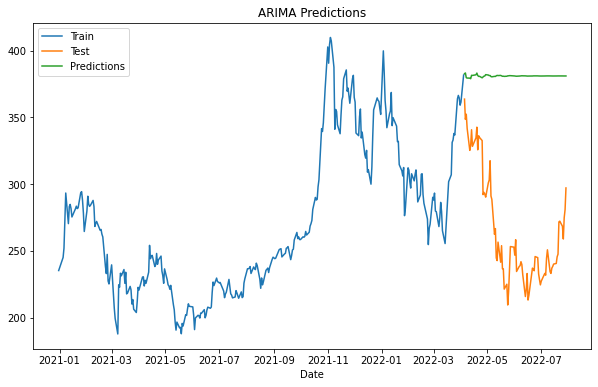

In [123]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(arima_predict, label='Predictions')
plt.title('ARIMA Predictions')
plt.legend()
plt.xlabel('Date')
plt.show()

In [125]:
arima_pred_diff = arima_predict.diff().dropna()

In [126]:
mae_arima = mean_absolute_error(diff_test.iloc[1:], arima_pred_diff)
mse_arima = mean_squared_error(diff_test.iloc[1:], arima_pred_diff)
rmse_arima = np.sqrt(mean_squared_error(diff_test.iloc[1:], arima_pred_diff))

In [127]:
arima_perf = {'mae_arima': mae_arima,
             'mse_arima':mse_arima,
             'rmse_arima':rmse_arima}
arima_perf = pd.DataFrame([arima_perf])
arima_perf

,mae_arima,mse_arima,rmse_arima
0,9.118062,146.119011,12.08797


In [130]:
arima_model = ARIMA(tsla_close, order=(8, 1, 8)).fit()
arima_forecast = arima_model.forecast(steps=10)
arima_forecast.index = forecast_index

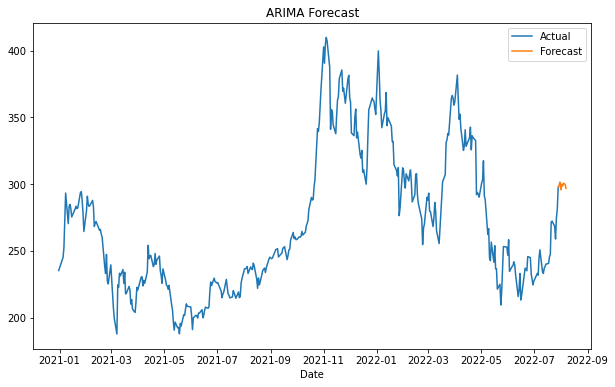

In [131]:
plt.plot(tsla_close, label='Actual')
plt.plot(arima_forecast, label='Forecast')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.legend()
plt.show()

Ok, as expected, we have a very similar result with ARMA. Simply because, ARIMA just accept non-stationary data by design but convert it into stationary one using difference `d` parameter.

## SARIMA

Do you think that the data that you are trying to model exhibit seasonality? Well, this is your model.

SARIMA stands for `Seasonal-ARIMA` and it has additional seasonal component differently from ARMA and ARIMA. The importance of seasonality is quite evident and ARIMA fails to encapsulate that information implicitly.

So, SARIMA has non-seasonal and seasonal parts. We know the non-seasonal part. Let's discuss the non-seasonal part.

* P is seasonal AR order
* D is seasonal differencing
* Q is seasonal MA order
* m is time span of repeating seasonal pattern


In [134]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(train, order=(8, 1, 8), seasonal_order=(0, 1, 1 , 12))
sarima_results = sarima_model.fit(disp=0)

In [135]:
sarima_pred = sarima_results.predict(start, end)
sarima_pred.index = test.index

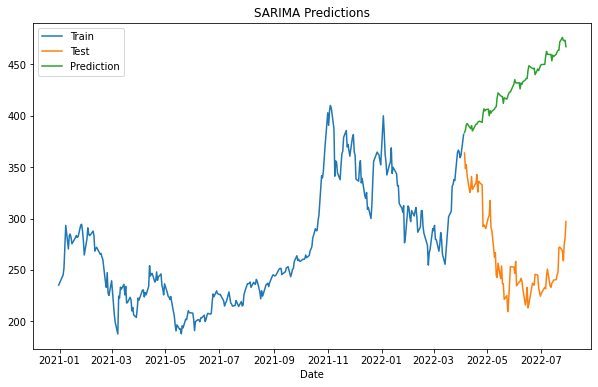

In [136]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(sarima_pred, label='Prediction')
plt.legend()
plt.title('SARIMA Predictions')
plt.xlabel('Date')
plt.show()

In [139]:
sarima_pred_diff = sarima_pred.diff().dropna()

In [140]:
mae_sarima = mean_absolute_error(diff_test.iloc[1:], sarima_pred_diff)
mse_sarima = mean_squared_error(diff_test.iloc[1:], sarima_pred_diff)
rmse_sarima = np.sqrt(mean_squared_error(diff_test.iloc[1:], sarima_pred_diff))

In [141]:
sarima_perf = {'mae_sarima': mae_sarima,
             'mse_sarima':mse_sarima,
             'rmse_sarima':rmse_sarima}
sarima_perf = pd.DataFrame([sarima_perf])
sarima_perf

,mae_sarima,mse_sarima,rmse_sarima
0,10.149482,173.761765,13.181873


In [142]:
sarima_model = SARIMAX(tsla_close, order=(8, 1, 8), seasonal_order=(0, 1, 1 , 12))
sarima_results = sarima_model.fit(disp=0)
sarima_forecast = sarima_results.forecast(steps=10)
sarima_forecast.index = forecast_index

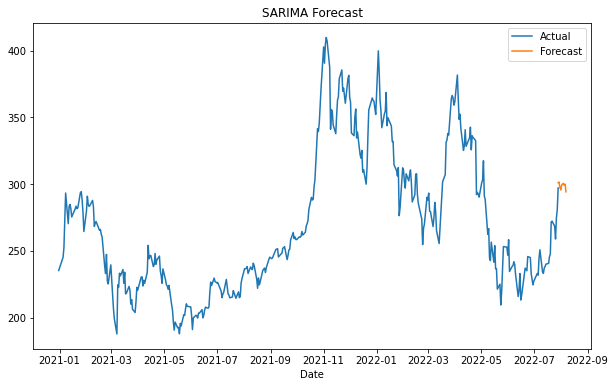

In [143]:
plt.plot(tsla_close, label='Actual')
plt.plot(sarima_forecast, label='Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.xlabel('Date')
plt.show()

Congrats, this was long one but finally you made it!

# Multivariate Time Series Analysis

Thus far, we have discussed the univariate time series models. But, let's think for a second if a univariate model can explain today's complex problems? I bet you guess right. It does not! So, what are we going to do? Simple, we are going to use a time series model with more independent variables, which makes it multivariate time series analysis.

Do not worry, the working logic of time series model will be the same but we will introduce a new parameter called `exogenous` (exog) and, of course, we have a endogenous variable as we have always.

## The concept of endogenous and exogenous variables

Endogenous variables is the variable that is determined within the system (or equation). An endogenous variable is synonymous with a dependent variable. In fact, the ultimate aim of the modeling is to explain the changes in dependent variable using independent variables.

In the time-series context, endogenous variable is stock price at time t (current time). Which variables are used to account for the changes in endogenous variable? As you can guess: `Exogenous` variable(s).

So, we just use a single exogenous variable, which is lagged values of endogenous variable. So, it is $X_{t-1}$, $X_{t-2}$, ... and others.

In multivariate time series analysis, we are going to take advantage of many exogenous variables in the sense that we are more capable of explaining the endogenous variable. Formally speaking, exogenous variable, unlike endogenous model, is determined outside the model.

In Python, the parameter `exog` is created for exogenous variable and we will use it in our model. In this module, SARIMAX and Vector Autoregressive (VAR) models will be employed.

## Introduction to SARIMAX: A brief theoretical background 

As you may remember, if you want to add seasonal component to ARIMA, it becomes SARIMA. In SARIMA, we have both non-seasonal and seasonal orders. Non-seasonal orders are:

* p: Autoregressive order
* d: Differencing order
* q: Moving average order

Seasonal orders are:

* P: Seasonal autoregressive order
* D: Seasonal differencing order
* Q: Seasonal moving average order
* S: Length of the seasonal cycle

In order to obtain SARIMAX, all we need to do is to add more exogenous variables to the SARIMA. This brings in a tremendous explanatory power to the model if it is properly defined and exogenous variables are chosen well.

This feature of the model differs from other models. For instance, in a univariate time series, the sales has seasonal affect in coastal area, that is to say, it is higher during summer and lower in winter. However, some special days might also impact on sales. National days should have positive impact on sales. So, this is not something we can capture with other models.

## Modeling with SARIMAX

In [144]:
stock = 'TSLA'
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2022, 8, 1)
tsla = yf.download(stock, start=start, end=end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [145]:
tsla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31,233.330002,239.573334,230.373337,235.223328,235.223328,148949700
2021-01-04,239.820007,248.163330,239.063339,243.256668,243.256668,145914600
2021-01-05,241.220001,246.946671,239.733337,245.036667,245.036667,96735600
2021-01-06,252.830002,258.000000,249.699997,251.993332,251.993332,134100000
2021-01-07,259.209991,272.329987,258.399994,272.013336,272.013336,154496700


In [146]:
tsla.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [147]:
tsla_filtered = tsla[['Open', 'High', 'Low','Volume']]
X = tsla_filtered
y = tsla['Close']

In [148]:
train_len = int(len(train) * 0.8)
X_train, y_train = X[:train_len], y[:train_len]
X_test, y_test = X[train_len:], y[train_len:]

In [150]:
sarimax = SARIMAX(y_train, exog=X_train, order=(8, 1, 8))
sarimax_result = sarimax.fit(disp=0)

## Running prediction and forecasting with SARIMAX

In [156]:
start = len(X_train)
end = len(X_train) + len(X_test) - 1 

In [157]:
sarimax_pred = sarimax_result.predict(start, end, exog=X_test)

In [158]:
sarimax_pred.index = X_test.index

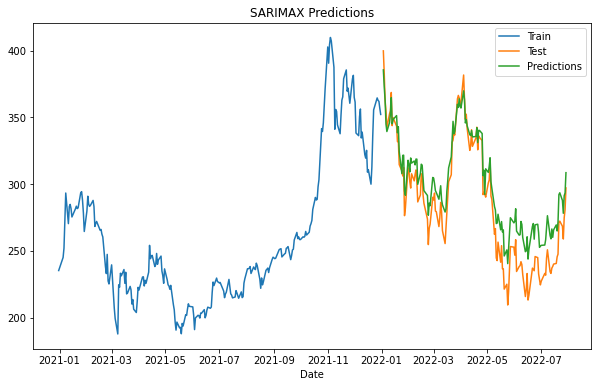

In [187]:
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(sarimax_pred, label='Predictions')
plt.legend()
plt.xlabel('Date')
plt.title('SARIMAX Predictions')
plt.show()

In [161]:
mae_sarimax = mean_absolute_error(y_test, sarimax_pred)
mse_sarimax = mean_squared_error(y_test, sarimax_pred)
rmse_sarimax = np.sqrt(mean_squared_error(y_test, sarimax_pred))

In [162]:
sarimax_perf = {'mae_sarimax': mae_sarimax,
             'mse_sarimax':mse_sarimax,
             'rmse_sarimax':rmse_sarimax}
sarimax_perf = pd.DataFrame([sarimax_perf])
sarimax_perf

,mae_sarimax,mse_sarimax,rmse_sarimax
0,15.557885,334.511469,18.289655


In [165]:
stock = 'TSLA'
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2022, 8, 11)
tsla = yf.download(stock, start=start, end=end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [166]:
forecasted_exog = tsla[['Open', 'High', 'Low','Volume']].iloc[-10:]

In [168]:
sarimax = SARIMAX(y, exog=X, order=(8, 1, 8))
sarimax_result = sarimax.fit(disp=0)

In [172]:
sarimax_result = sarimax_result.forecast(steps=10, exog=forecasted_exog)

In [184]:
sarimax_result.index = pd.date_range(tsla.index[-8], periods=10)

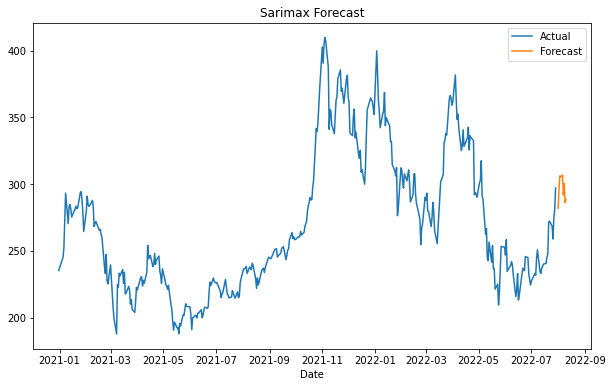

In [186]:
plt.plot(y, label='Actual')
plt.plot(sarimax_result, label='Forecast')
plt.title('Sarimax Forecast')
plt.legend()
plt.xlabel('Date')
plt.show()